# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [24]:
import pandas as pd
import matplotlib

In [12]:
df = pd.read_csv('zillow_data.csv')

In [13]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [85]:
df['RegionName'].value_counts().unique()

array([1])

# Step 2: Data Preprocessing

In [20]:
def get_datetimes(df, first_date_col):
    """
    Converts year-month column headings to date-time.
    
    Args: 
        df: a dataframe with column headdings that are formatted yyyy-mm
        All columns follwing first_date_col should have same format
        first_date_col: the index of the first date column or first column 
        you want converted.
    Returns:
        Series of datetime64 dtype
    """
    return pd.to_datetime(df.columns.values[(first_date_col):], format='%Y-%m')

In [21]:
datetimes = get_datetimes(df, 7)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


# Step 3: EDA and Visualization

In [25]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [56]:
data = df.loc[df['City'] == 'Chicago', '1996-04':]

In [57]:
data.head(100)

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,216500.0,216700.0,216900.0,217000.0,217100.0,217200.0,217500.0,217900.0,218600.0,219700.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,122700.0,122800.0,122800.0,122700.0,122400.0,122000.0,121500.0,120900.0,120500.0,120300.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,142600.0,143100.0,143400.0,143300.0,142900.0,142200.0,141300.0,140100.0,139000.0,138000.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300
40,297900.0,300400.0,302600.0,304700.0,306600.0,308400.0,310200.0,311800.0,314100.0,316600.0,...,1015000,1017600,1020900,1027800,1034400,1041300,1051300,1059300,1060200,1055300
48,93400.0,94100.0,94600.0,94800.0,94700.0,94200.0,93500.0,92500.0,91600.0,90800.0,...,157600,158600,159500,160600,161700,162600,163500,164000,164000,163800
50,148900.0,149300.0,149600.0,149700.0,149700.0,149400.0,149100.0,148500.0,148100.0,147900.0,...,452300,453600,456000,459100,461900,463100,464100,464200,463200,461100
74,76400.0,77000.0,77400.0,77700.0,77700.0,77500.0,77200.0,76600.0,76200.0,75800.0,...,128200,129000,129100,128500,127900,127800,127100,126800,128000,129600
79,435200.0,435200.0,435100.0,434600.0,433900.0,433100.0,432200.0,431200.0,430700.0,430500.0,...,1044200,1041800,1038100,1039200,1042000,1045700,1050800,1050400,1045000,1039700


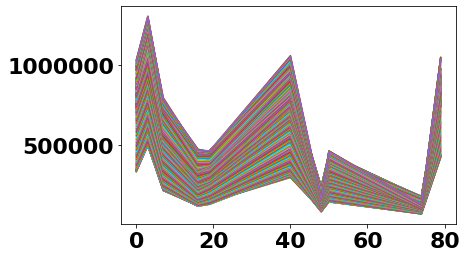

In [58]:
plt.plot(data.head(10))
plt.show();

# Step 4: Reshape from Wide to Long Format

In [74]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [121]:
melted_df = melt_data(df)

In [122]:
melted_df.head()

,value
time,
1996-04-01,118299.123063
1996-05-01,118419.044139
1996-06-01,118537.423268
1996-07-01,118653.069278
1996-08-01,118780.254312


In [131]:
chicago_melted = melt_data(df.loc[df['City'] == 'Chicago'])

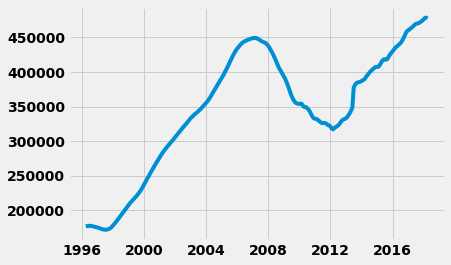

In [132]:
plt.plot(chicago_melted)
plt.show()

# Step 5: ARIMA Modeling

In [133]:
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
plt.style.use('fivethirtyeight')
from fbprophet import Prophet as proph

In [137]:
chicago_melted.loc['2000-01-01': '2011-01-01']

,value
time,
2000-01-01,237195.0
2000-02-01,240680.0
2000-03-01,243980.0
2000-04-01,247362.5
2000-05-01,250765.0
...,...
2010-09-01,343257.5
2010-10-01,339195.0
2010-11-01,335867.5


In [146]:
def model_price(df, start, end, periods=36, freq='MS', interval_width=0.80):
    df = df.reset_index()
    df.columns = ['ds', 'y']
    data = df.loc[(df['ds'] > start) & (df['ds'] < end)]
    print(data)
    Model = proph(interval_width=interval_width)
    Model.fit(data)
    future_dates = Model.make_future_dataframe(periods=periods, freq=freq)
    forecast = Model.predict(future_dates)
    return Model

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds         y
46  2000-02-01  240680.0
47  2000-03-01  243980.0
48  2000-04-01  247362.5
49  2000-05-01  250765.0
50  2000-06-01  254150.0
..         ...       ...
172 2010-08-01  345862.5
173 2010-09-01  343257.5
174 2010-10-01  339195.0
175 2010-11-01  335867.5
176 2010-12-01  333267.5

[131 rows x 2 columns]


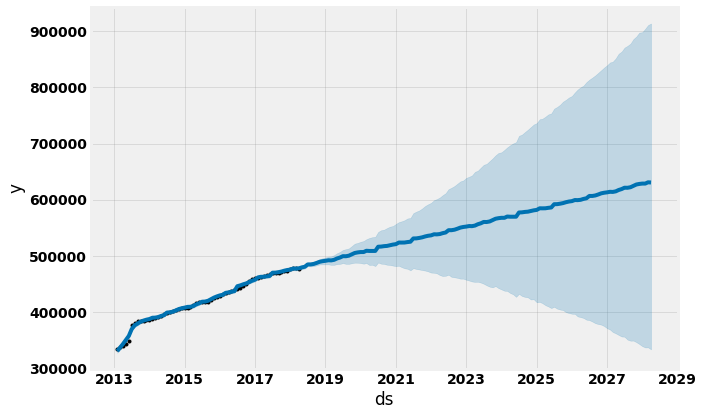

In [147]:
model = model_price(chicago_melted, '2000-01-01', '2011-01-01')
Model.plot(forecast, uncertainty=True)
plt.show()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-02-01,329685.098553,327742.591914,333836.217554,329685.098553,329685.098553,1169.932963,1169.932963,1169.932963,1169.932963,1169.932963,1169.932963,0.0,0.0,0.0,330855.031516
1,2013-03-01,336811.673261,333559.729766,339884.938427,336811.673261,336811.673261,-88.895425,-88.895425,-88.895425,-88.895425,-88.895425,-88.895425,0.0,0.0,0.0,336722.777836
2,2013-04-01,344701.809546,340578.979229,346321.553731,344701.809546,344701.809546,-1277.491416,-1277.491416,-1277.491416,-1277.491416,-1277.491416,-1277.491416,0.0,0.0,0.0,343424.318129
3,2013-05-01,352337.425317,347363.140938,353641.592774,352337.425317,352337.425317,-1728.186432,-1728.186432,-1728.186432,-1728.186432,-1728.186432,-1728.186432,0.0,0.0,0.0,350609.238885
4,2013-06-01,360227.561615,354788.809838,360714.337353,360227.561615,360227.561615,-2395.199557,-2395.199557,-2395.199557,-2395.199557,-2395.199557,-2395.199557,0.0,0.0,0.0,357832.362058


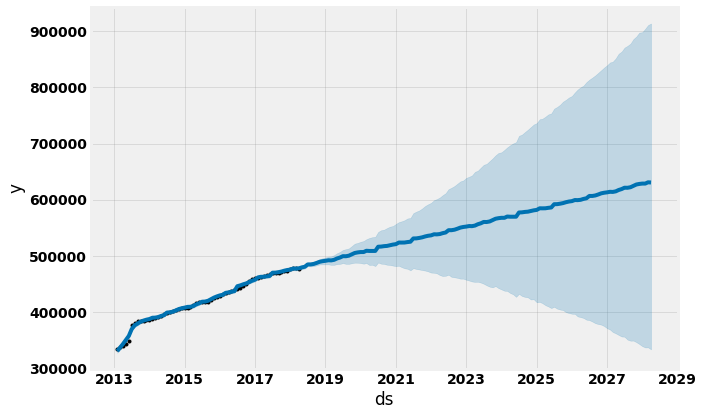

# Step 6: Interpreting Results